In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from datasets import Dataset, DatasetDict, load_dataset

In [3]:
import re


def split_camel_case(input_str):
    # Use regular expression to find word boundaries in camel case
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', input_str)
    # Extract the words and return as a list
    return [m.group(0) for m in matches]

In [4]:
import random

import numpy as np


def set_seed(seed):
    np.random.seed(seed % (2**32 - 1))
    random.seed(seed)

SEED = 89
set_seed(SEED)

In [5]:
def _transform_relation(relation: str):
    return " ".join([word.lower() for word in split_camel_case(relation)]).strip()


def _transform_entity(entity: str):
    return entity.replace("_", " ").strip()


def _transform_triple(triple_string: str):
    delimiter = " | "
    triple_string = triple_string.replace('"', "").replace("''", "")
    subject, relation, obj = triple_string.split(delimiter)
    relation = _transform_relation(relation)
    subject = _transform_entity(subject)
    obj = _transform_entity(obj)
    return delimiter.join([subject, relation, obj])



def _batch_transform(examples):
    for eid, lex, mts in zip(examples["eid"], examples["lex"], examples["modified_triple_sets"]):
        for text in lex["text"]:
            triples = [_transform_triple(triplet_string) for triplet_string in mts["mtriple_set"][0]]
            yield dict(eid=eid, text=text, triples=triples)


def batch_transform(examples):
    records = list(_batch_transform(examples))
    return {
        "eid": [record["eid"] for record in records],
        "text": [record["text"] for record in records],
        "triples": [record["triples"] for record in records],
    }

In [6]:
hf_username = 'bdsaglam'

In [7]:

dataset_path = "web_nlg"
dataset_name = "release_v3.0_en"
dsd = load_dataset(dataset_path, dataset_name, trust_remote_code=True)

In [8]:
dsd['train'][0]

{'category': 'Airport',
 'size': 1,
 'eid': 'Id1',
 'original_triple_sets': {'otriple_set': [['Aarhus_Airport | cityServed | "Aarhus, Denmark"@en']]},
 'modified_triple_sets': {'mtriple_set': [['Aarhus_Airport | cityServed | "Aarhus, Denmark"']]},
 'shape': '(X (X))',
 'shape_type': 'NA',
 'lex': {'comment': ['good', 'good'],
  'lid': ['Id1', 'Id2'],
  'text': ['The Aarhus is the airport of Aarhus, Denmark.',
   'Aarhus Airport serves the city of Aarhus, Denmark.'],
  'lang': ['', '']},
 'test_category': '',
 'dbpedia_links': [],
 'links': []}

In [9]:
dsd['train'][25]

{'category': 'Airport',
 'size': 1,
 'eid': 'Id26',
 'original_triple_sets': {'otriple_set': [['Adirondack_Regional_Airport | r1LengthF | 6573']]},
 'modified_triple_sets': {'mtriple_set': [['Adirondack_Regional_Airport | 1stRunwayLengthFeet | 6573']]},
 'shape': '(X (X))',
 'shape_type': 'NA',
 'lex': {'comment': ['good', 'good', 'good'],
  'lid': ['Id1', 'Id2', 'Id3'],
  'text': ['The length of the first runway at Adirondack Regional Airport is 6,573 feet.',
   '6573 feet is the length of the first runway at Adirondack Regional Airport.',
   'The 1st runway length in feet of Adirondack Regional Airport is 6573.'],
  'lang': ['', '', '']},
 'test_category': '',
 'dbpedia_links': [],
 'links': []}

In [10]:
from datasets import load_dataset

dsd = load_dataset("web_nlg", "release_v3.0_en", trust_remote_code=True)
erx_dsd = dsd.map(batch_transform, batched=True, remove_columns=dsd['train'].column_names)

In [11]:
dsd['train'][0]

{'category': 'Airport',
 'size': 1,
 'eid': 'Id1',
 'original_triple_sets': {'otriple_set': [['Aarhus_Airport | cityServed | "Aarhus, Denmark"@en']]},
 'modified_triple_sets': {'mtriple_set': [['Aarhus_Airport | cityServed | "Aarhus, Denmark"']]},
 'shape': '(X (X))',
 'shape_type': 'NA',
 'lex': {'comment': ['good', 'good'],
  'lid': ['Id1', 'Id2'],
  'text': ['The Aarhus is the airport of Aarhus, Denmark.',
   'Aarhus Airport serves the city of Aarhus, Denmark.'],
  'lang': ['', '']},
 'test_category': '',
 'dbpedia_links': [],
 'links': []}

In [12]:
erx_dsd['train'][0]

{'eid': 'Id1',
 'text': 'The Aarhus is the airport of Aarhus, Denmark.',
 'triples': ['Aarhus Airport | city served | Aarhus, Denmark']}

In [13]:
assert 'eid' in erx_dsd['train'].features
assert 'text' in erx_dsd['train'].features
assert 'triples' in erx_dsd['train'].features
assert isinstance(erx_dsd['train'][0]['triples'], list)
assert isinstance(erx_dsd['train'][0]['triples'][0], str)

In [14]:
new_dataset_path = f"{hf_username}/{dataset_path.split('/', 1)[-1]}-erx"
erx_dsd.push_to_hub(new_dataset_path, config_name=dataset_name)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/36 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/bdsaglam/web_nlg-erx/commit/d1ceceebd5b37932882e860431e6a2481f2a9f12', commit_message='Upload dataset', commit_description='', oid='d1ceceebd5b37932882e860431e6a2481f2a9f12', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/bdsaglam/web_nlg-erx', endpoint='https://huggingface.co', repo_type='dataset', repo_id='bdsaglam/web_nlg-erx'), pr_revision=None, pr_num=None)

In [15]:
#|export

import random
from typing import Generator, TypeVar

T = TypeVar("T")


def chunk_random(lst: list[T], min_chunk: int = 2, max_chunk: int = 4) -> Generator[list[T], None, None]:
    """
    Splits a list into random-sized chunks.

    Args:
        lst (list): The list to be split into chunks.
        min_chunk (int, optional): The minimum size of each chunk. Defaults to 2.
        max_chunk (int, optional): The maximum size of each chunk. Defaults to 4.

    Yields:
        list: A chunk of the original list.

    Returns:
        list: A list of chunks.

    """
    # Ensure the list has at least the minimum number of elements required for a chunk
    if len(lst) < min_chunk:
        yield lst
        return

    i = 0  # Initialize an index to traverse the list
    while i < len(lst):
        if len(lst) - i < min_chunk:
            break
        # Determine the size of the next chunk
        chunk_size = random.randint(min_chunk, min(max_chunk, len(lst) - i))
        # Add the chunk to the list of chunks
        yield lst[i : i + chunk_size]
        # Increment the index by the size of the chunk just added
        i += chunk_size

def chunk_random_dataset(ds, min_chunk=1, max_chunk=3):
    for indices in chunk_random(range(len(ds)), min_chunk, max_chunk):
        yield ds.select(indices).to_list()


In [16]:
# we need to vary length of examples for training so that LLM is more robust to the input length
# we can do this by concatenating multiple examples together


def concat_examples(examples):
    return {
        "eid": "\n".join([example["eid"] for example in examples]),
        "text": "\n".join([example["text"] for example in examples]),
        "triples": [triple for example in examples for triple in example["triples"]],
    }


concat_erx_dsd = DatasetDict(
    {
        k: Dataset.from_list(
            [{"chunk": chunk} for chunk in chunk_random_dataset(ds.shuffle(SEED), min_chunk=1, max_chunk=7)]
        )
        for k, ds in erx_dsd.items()
    }
).map(lambda x: concat_examples(x["chunk"]), remove_columns=["chunk"])
concat_erx_dsd.push_to_hub(new_dataset_path + "-concat", config_name=dataset_name)

Map:   0%|          | 0/8871 [00:00<?, ? examples/s]

Map:   0%|          | 0/1116 [00:00<?, ? examples/s]

Map:   0%|          | 0/1834 [00:00<?, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/bdsaglam/web_nlg-erx-concat/commit/e7aa67f483ea11914bcbd033cd51f2033261ba94', commit_message='Upload dataset', commit_description='', oid='e7aa67f483ea11914bcbd033cd51f2033261ba94', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/bdsaglam/web_nlg-erx-concat', endpoint='https://huggingface.co', repo_type='dataset', repo_id='bdsaglam/web_nlg-erx-concat'), pr_revision=None, pr_num=None)

In [17]:
concat_erx_dsd['train'][0]

{'eid': 'Id62',
 'text': 'Adonis Georgiadis is a member of the Greek New Democracy Party which uses the colour blue. Before being succeeded by Makis Voridis he served in office while Antonis Samaras was Prime Minister and Evangelos Venizelos was Deputy.',
 'triples': ['Adonis Georgiadis | in office while prime minister | Antonis Samaras',
  'Antonis Samaras | has deputy | Evangelos Venizelos',
  'New Democracy (Greece) | colour | Blue',
  'Adonis Georgiadis | party | New Democracy (Greece)',
  'Adonis Georgiadis | successor | Makis Voridis']}

In [18]:
df = concat_erx_dsd['train'].to_pandas()

<Axes: >

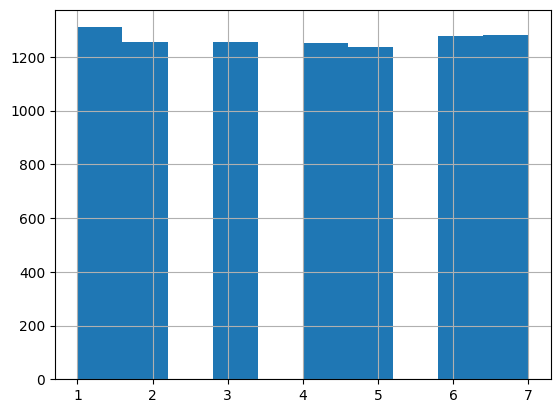

In [21]:
df['eid'].map(str.splitlines).map(len).hist()